In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

# Import Libraries here
import os
import json 
import shutil
import zipfile

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Set paths that you'll use in this notebook
root_dir = "/home/adeperio/"

# notebook project directories
base_dir = root_dir + 'ml/pcam/'
!mkdir -p "{base_dir}"

In [2]:
# set the random seed
np.random.seed(2)

In [ ]:
# First we make sure we have the kaggle sdk installed.
# We assume here that on your machine you have the kaggle.json token file in ~/.kaggle/
!pip install kaggle

In [ ]:
# Can list available Kaggle competitions here if needed
# !kaggle competitions list

# Download the histopathological data
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}"

In [ ]:
#now unzip the training files
!mkdir -p "{base_dir}train/"
dest_dir_train = Path(base_dir + 'train/')
print(base_dir + 'train.zip')
train_zip = zipfile.ZipFile(base_dir + 'train.zip', 'r')
train_zip.extractall(dest_dir_train)
train_zip.close()

In [ ]:
#now unzip the test files
!mkdir -p "{base_dir}test/"
dest_dir_test = Path(base_dir + 'test/')
test_zip = zipfile.ZipFile(base_dir + 'test.zip', 'r')
test_zip.extractall(dest_dir_test)
test_zip.close()
  

In [ ]:
# then extract the labels 
dest_dir_csv = Path(base_dir)
labels_csv_zip = zipfile.ZipFile(base_dir + 'train_labels.csv.zip', 'r')
labels_csv_zip.extractall(dest_dir_csv)
labels_csv_zip.close()

In [4]:
# Check the download here
path = Path(base_dir)
path.ls()

[PosixPath('/home/adeperio/ml/pcam/test'),
 PosixPath('/home/adeperio/ml/pcam/.ipynb_checkpoints'),
 PosixPath('/home/adeperio/ml/pcam/pcam-ml-ubuntu.ipynb'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-50-unfrozen.pth'),
 PosixPath('/home/adeperio/ml/pcam/stage-1.pth'),
 PosixPath('/home/adeperio/ml/pcam/train_labels.csv'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-50.pth'),
 PosixPath('/home/adeperio/ml/pcam/test.txt'),
 PosixPath('/home/adeperio/ml/pcam/models'),
 PosixPath('/home/adeperio/ml/pcam/train'),
 PosixPath('/home/adeperio/ml/pcam/sample_submission.csv.zip'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-34.pth'),
 PosixPath('/home/adeperio/ml/pcam/train_labels.csv.zip'),
 PosixPath('/home/adeperio/ml/pcam/train.zip'),
 PosixPath('/home/adeperio/ml/pcam/stage-1-50-1.pth'),
 PosixPath('/home/adeperio/ml/pcam/test.zip')]

In [3]:
tfms = get_transforms(do_flip=True)

In [4]:
bs=64 # also the default batch size
data = ImageDataBunch.from_csv(
    base_dir, 
    ds_tfms=tfms, 
    size=224, 
    suffix=".tif",
    folder="train", 
    test="test",
    csv_labels="train_labels.csv", 
    bs=bs)

In [5]:
# now normalise the images
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,1
Path: /home/adeperio/ml/pcam;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: /home/adeperio/ml/pcam;

Test: LabelList (57458 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/adeperio/ml/pcam

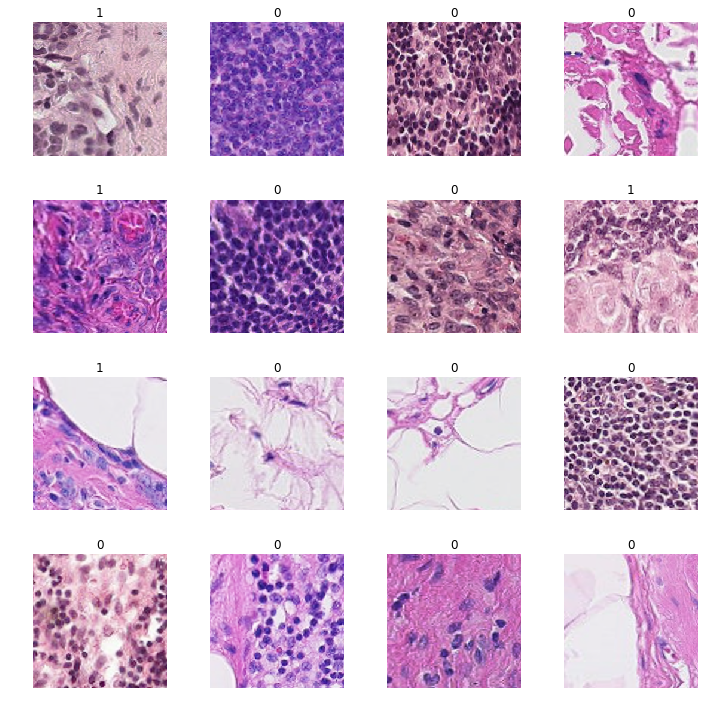

In [8]:
data.show_batch(rows=4, figsize=(10, 10))

In [6]:
# I am using a GPU that supports 16bit precision, so we also switch this support mode to on. 
# If your GPU does not have that support you can omit the to_fp16() call
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=ShowGraph).to_fp16()

In [7]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


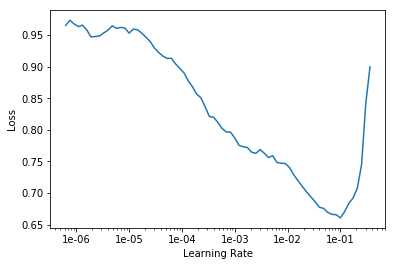

In [8]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.239715,0.193532,0.075151,10:23
1,0.205948,0.153948,0.057380,10:23
2,0.174833,0.126729,0.044495,10:26
3,0.170107,0.119771,0.041268,10:26
4,0.143925,0.113238,0.038427,10:26
5,0.149095,0.126973,0.042063,10:26
6,0.153990,0.114695,0.037928,10:26
7,0.136065,0.111566,0.036132,10:25
8,0.133533,0.160982,0.034564,10:26
9,0.139547,0.135928,0.039155,10:25


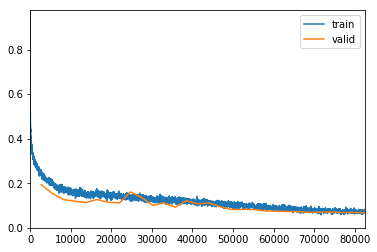

In [9]:
learn.fit_one_cycle(30, slice(1e-02))

In [10]:
learn.save(base_dir + 'pcamv4-stage-1')

In [8]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 97.75934600830078 %.


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

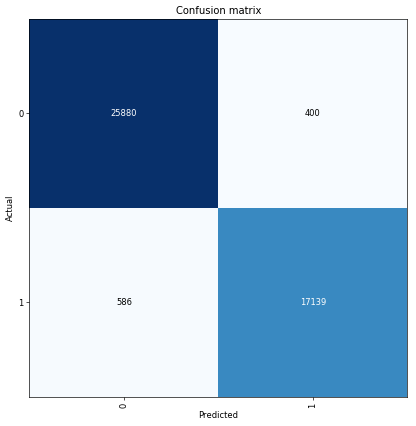

In [16]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

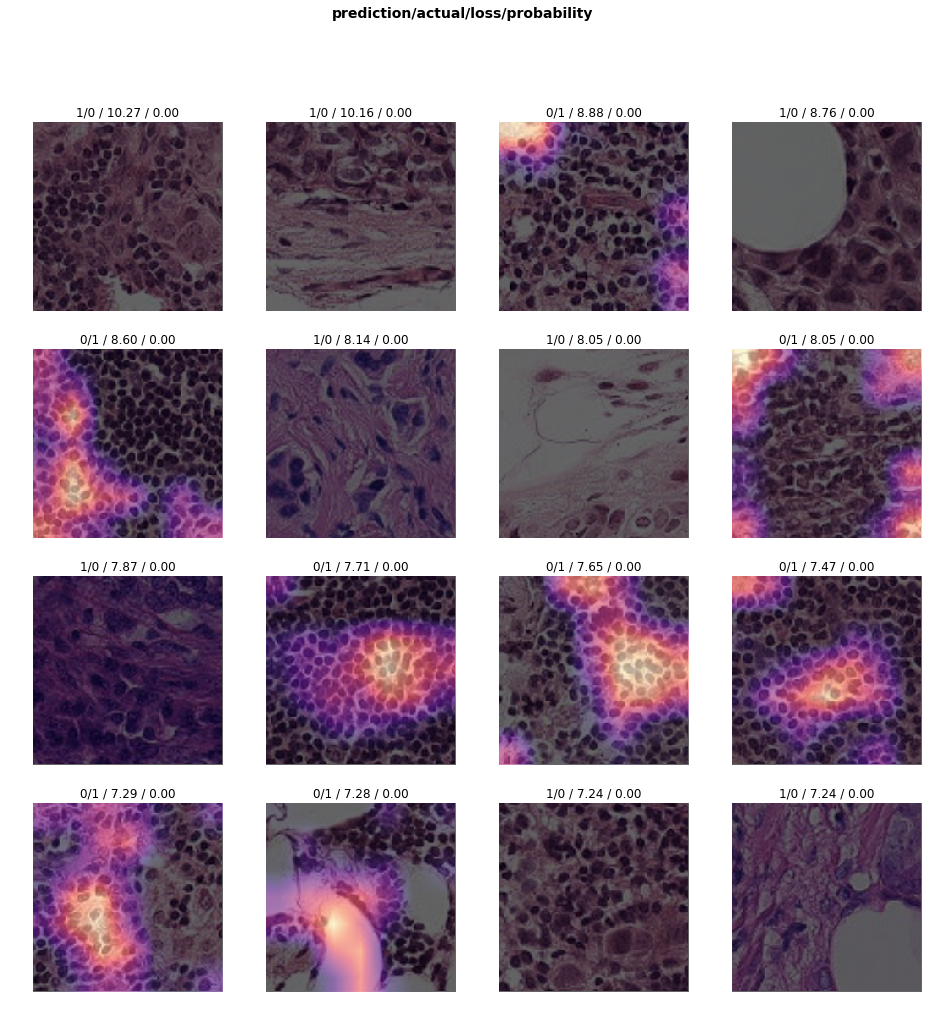

In [14]:
interp.plot_top_losses(16, figsize=(16,16))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


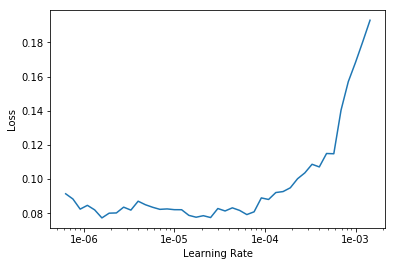

In [65]:
# Using the plot from the learning rate finder above, 
# find a value for the first value in the max_lr slice 
# that is well before the point when the loss start to significantly degrade
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()


epoch,train_loss,valid_loss,error_rate,time
0,0.068424,0.066296,0.021475,13:17
1,0.085035,0.068620,0.022861,13:19
2,0.077056,0.072795,0.024724,13:19
3,0.082423,0.076358,0.025315,13:22
4,0.094262,0.075467,0.025202,13:19
5,0.089292,0.095523,0.031724,13:21
6,0.082299,0.069068,0.022634,13:21
7,0.085847,0.074969,0.025293,13:20
8,0.067565,0.072602,0.023634,13:21
9,0.082363,0.066331,0.022520,13:21


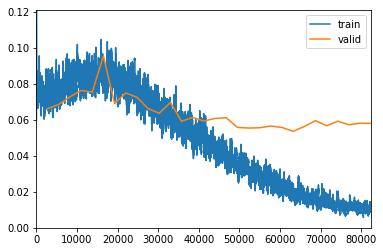

In [66]:
learn.fit_one_cycle(30, max_lr=slice(1e-5,1e-4))

In [67]:
learn.save(base_dir + 'pcamv4-stage-2')

In [17]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 98.59561157226562 %.


In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

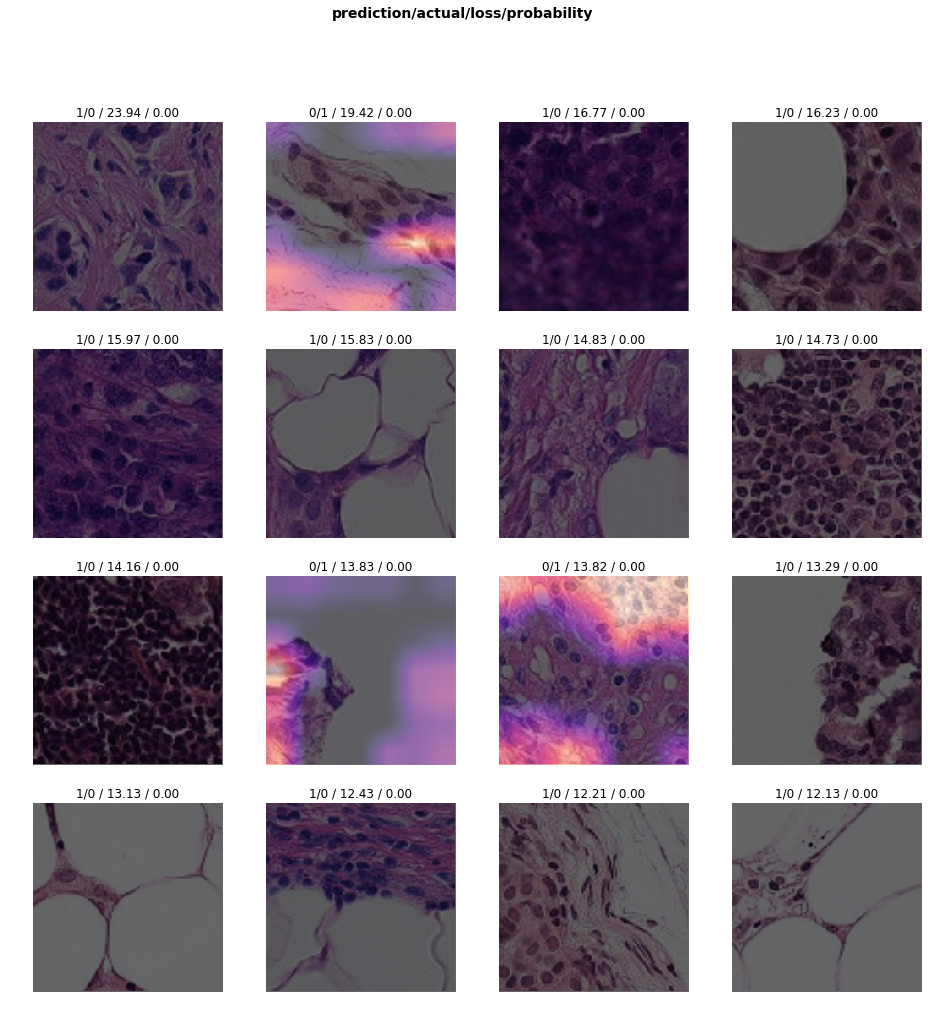

In [21]:
interp.plot_top_losses(16, figsize=(16,16))